In [2]:
import GLPK
solver = GLPK.Optimizer;
import QHull
Qlib = QHull.Library(solver);

┌ Info: Precompiling QHull [a8468747-bd6f-53ef-9e5c-744dbc5c59e7]
└ @ Base loading.jl:1260


In [3]:
import SwitchOnSafety
include(joinpath(dirname(dirname(pathof(SwitchOnSafety))), "examples", "cruise_control.jl"));

┌ Info: Precompiling SwitchOnSafety [ceb7f16a-07bf-5f4a-9354-b68f01b1610f]
└ @ Base loading.jl:1260


In [16]:
import CDDLib
lib = CDDLib.Library();

┌ Info: Precompiling CDDLib [3391f64e-dcde-5f30-b752-e11513730f60]
└ @ Base loading.jl:1260


In [147]:
hsys = cruise_control_example(1, 1, vmin=vmin, vmax=vmax, v=v,
                              U=U, H=h*T, D=D, T=T, sym=true, m0 = m0, ks=ks, m=m, kd=kd, lib=Qlib)

Hybrid System with automaton GraphAutomaton{Graphs.SimpleGraphs.SimpleDiGraph{Int64},Graphs.SimpleGraphs.SimpleEdge{Int64}}({1, 1} directed simple Int64 graph, Dict{Graphs.SimpleGraphs.SimpleEdge{Int64},Dict{Int64,Int64}}(Edge 1 => 1 => Dict(1 => 1)), 1, 1)

In [22]:
hsys = system(1, 1; sym=true, lib = lib)
sys_control = hsys.resetmaps[1]
sys_alg = SwitchOnSafety.algebraiclift(sys_control)
sys_alg.A

3×4 Array{Float64,2}:
 1.0   -0.5   0.5   0.0
 0.25   0.75  0.25  0.0
 0.25   0.25  0.75  0.5

In [23]:
typeof(sys_alg)

LinearAlgebraicDiscreteSystem{Float64,Array{Float64,2},Array{Float64,2}}

In [4]:
function fixed_point_iteration(set::Polyhedron, sys::LinearAlgebraicDiscreteSystem)
    new_set = set ∩ (sys.A \ (sys.E * set))
    removehredundancy!(new_set)
    return new_set::typeof(set)
end
iterate!(sets, sys) = push!(sets, fixed_point_iteration(sets[end], sys))
function iterate!(sets, sys, n)
    if n > 0
        iterate!(sets, sys)
        iterate!(sets, sys, n - 1)
    end
end
function _proj(P, I)
    Q = project(P, I)
    removehredundancy!(Q)
    return Q
end
_proj(Ps::Vector, I) = map(P -> _proj(P, I), Ps)

_proj (generic function with 2 methods)

In [39]:
X = [hsys.modes[1].X]
iterate!(X, sys_alg, 4)

In [71]:
X13 = _proj(X, [1, 3])
nhalfspaces.(X13)

5-element Array{Int64,1}:
 4
 6
 6
 6
 6

In [72]:
X14 = _proj(X, [1, 4])
nhalfspaces.(X14)

5-element Array{Int64,1}:
 4
 4
 4
 4
 4

In [73]:
X24 = _proj(X, [2, 4])
nhalfspaces.(X24)

5-element Array{Int64,1}:
 4
 4
 4
 4
 4

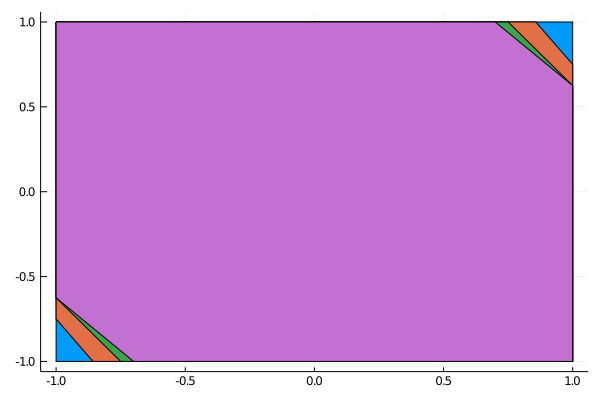

In [78]:
using Plots
plot(X13[1])
plot!(X13[2])
plot!(X13[3])
plot!(X13[4])

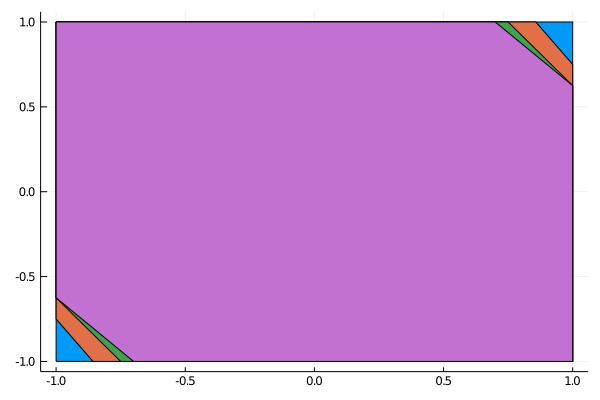

In [136]:
using Plots
plot(QX13[1])
plot!(QX13[2])
plot!(QX13[3])
plot!(QX13[4])

In [5]:
hsys = cruise_control_example(1, 1, vmin=vmin, vmax=vmax, v=v,
                              U=U, H=1/4, D=D, T=T, sym=true, m0 = m0, ks=1, m=2m0, kd=1/4, lib=Qlib)
sys_control = hsys.resetmaps[1]
sys_alg = SwitchOnSafety.algebraiclift(sys_control);

In [6]:
#Qhsys = system(1, 1; sym=true, lib = Qlib)
QX = [hsys.modes[1].X]
iterate!(QX, sys_alg, 10)

In [21]:
iterate!(QX, sys_alg, 5)

In [22]:
nhalfspaces.(QX)

46-element Array{Int64,1}:
  8
 14
 18
 22
 26
 30
 34
 38
 42
 46
 50
 54
 58
  ⋮
 98
 98
 98
 98
 98
 98
 98
 98
 98
 98
 98
 98

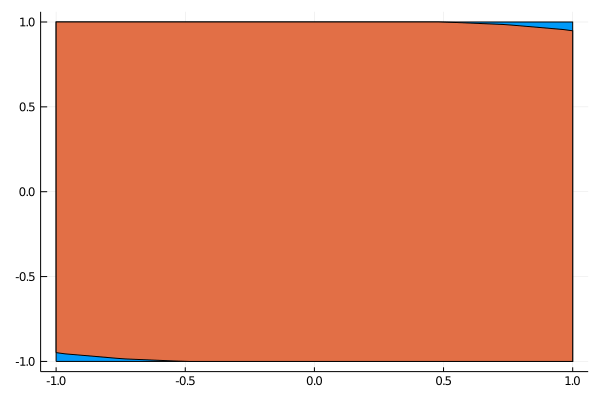

In [220]:
using Plots
plot(QX12[1])
#for i in 1:16
#    plot!(QX12[i])
#end
plot!(QX12[end])

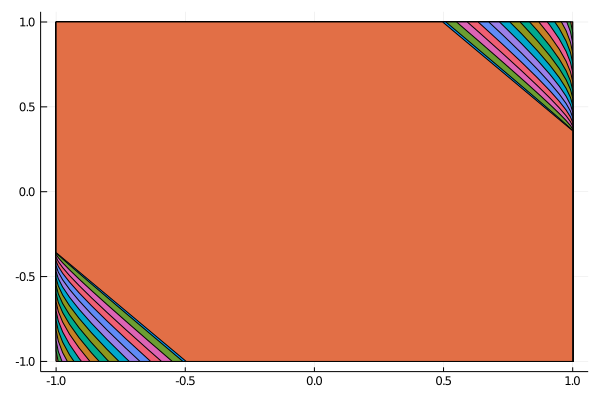

In [215]:
using Plots
plot(QX13[1])
for i in 1:16
    plot!(QX13[i])
end
plot!(QX13[end])

In [218]:
QX12 = _proj(QX, [1, 2])
collect(enumerate(nhalfspaces.(QX12)))

┌ Warning: Cannot detect exact linearity as no solver was provided and the polyhedron is not affine.
│ As fallback, we will only detect halfspaces from opposite hyperplanes but that may not detect all halfspaces.
│ Set a solver if you believe that the polyhedron may have more linearity.
│ To provide a solver to a polyhedron, first select a solver from https://www.juliaopt.org/JuMP.jl/stable/installation/#Getting-Solvers-1.
│ If you choose for instance `GLPK`, do `using GLPK; solver = GLPK.Optimizer`.
│ Then provide the solver to the library. For instance, with the default library, do `lib = DefaultLibrary{Float64}(solver)`
│ or if you use an external library, say `QHull`, do `lib = QHull.Library(solver)`.
│ Then when you create the polyhedron, say from a representation `rep`, do `polyhedron(rep, lib)`.
└ @ Polyhedra /home/blegat/.julia/packages/Polyhedra/Wu1SI/src/linearity.jl:208
┌ Warning: Cannot detect exact linearity as no solver was provided and the polyhedron is not affine.
│ As 

┌ Warning: Cannot detect exact linearity as no solver was provided and the polyhedron is not affine.
│ As fallback, we will only detect halfspaces from opposite hyperplanes but that may not detect all halfspaces.
│ Set a solver if you believe that the polyhedron may have more linearity.
│ To provide a solver to a polyhedron, first select a solver from https://www.juliaopt.org/JuMP.jl/stable/installation/#Getting-Solvers-1.
│ If you choose for instance `GLPK`, do `using GLPK; solver = GLPK.Optimizer`.
│ Then provide the solver to the library. For instance, with the default library, do `lib = DefaultLibrary{Float64}(solver)`
│ or if you use an external library, say `QHull`, do `lib = QHull.Library(solver)`.
│ Then when you create the polyhedron, say from a representation `rep`, do `polyhedron(rep, lib)`.
└ @ Polyhedra /home/blegat/.julia/packages/Polyhedra/Wu1SI/src/linearity.jl:208
┌ Warning: Cannot detect exact linearity as no solver was provided and the polyhedron is not affine.
│ As 

26-element Array{Tuple{Int64,Int64},1}:
 (1, 4)
 (2, 6)
 (3, 8)
 (4, 10)
 (5, 10)
 (6, 10)
 (7, 10)
 (8, 10)
 (9, 10)
 (10, 10)
 (11, 10)
 (12, 10)
 (13, 12)
 (14, 12)
 (15, 14)
 (16, 14)
 (17, 14)
 (18, 14)
 (19, 14)
 (20, 14)
 (21, 14)
 (22, 14)
 (23, 14)
 (24, 14)
 (25, 14)
 (26, 14)

In [217]:
QX13 = _proj(QX, [1, 3])
collect(enumerate(nhalfspaces.(QX13)))

┌ Warning: Cannot detect exact linearity as no solver was provided and the polyhedron is not affine.
│ As fallback, we will only detect halfspaces from opposite hyperplanes but that may not detect all halfspaces.
│ Set a solver if you believe that the polyhedron may have more linearity.
│ To provide a solver to a polyhedron, first select a solver from https://www.juliaopt.org/JuMP.jl/stable/installation/#Getting-Solvers-1.
│ If you choose for instance `GLPK`, do `using GLPK; solver = GLPK.Optimizer`.
│ Then provide the solver to the library. For instance, with the default library, do `lib = DefaultLibrary{Float64}(solver)`
│ or if you use an external library, say `QHull`, do `lib = QHull.Library(solver)`.
│ Then when you create the polyhedron, say from a representation `rep`, do `polyhedron(rep, lib)`.
└ @ Polyhedra /home/blegat/.julia/packages/Polyhedra/Wu1SI/src/linearity.jl:208
┌ Warning: Cannot detect exact linearity as no solver was provided and the polyhedron is not affine.
│ As 

┌ Warning: Cannot detect exact linearity as no solver was provided and the polyhedron is not affine.
│ As fallback, we will only detect halfspaces from opposite hyperplanes but that may not detect all halfspaces.
│ Set a solver if you believe that the polyhedron may have more linearity.
│ To provide a solver to a polyhedron, first select a solver from https://www.juliaopt.org/JuMP.jl/stable/installation/#Getting-Solvers-1.
│ If you choose for instance `GLPK`, do `using GLPK; solver = GLPK.Optimizer`.
│ Then provide the solver to the library. For instance, with the default library, do `lib = DefaultLibrary{Float64}(solver)`
│ or if you use an external library, say `QHull`, do `lib = QHull.Library(solver)`.
│ Then when you create the polyhedron, say from a representation `rep`, do `polyhedron(rep, lib)`.
└ @ Polyhedra /home/blegat/.julia/packages/Polyhedra/Wu1SI/src/linearity.jl:208
┌ Warning: Cannot detect exact linearity as no solver was provided and the polyhedron is not affine.
│ As 

26-element Array{Tuple{Int64,Int64},1}:
 (1, 4)
 (2, 6)
 (3, 8)
 (4, 10)
 (5, 12)
 (6, 14)
 (7, 14)
 (8, 16)
 (9, 18)
 (10, 18)
 (11, 20)
 (12, 20)
 (13, 22)
 (14, 22)
 (15, 22)
 (16, 24)
 (17, 6)
 (18, 6)
 (19, 6)
 (20, 6)
 (21, 6)
 (22, 6)
 (23, 6)
 (24, 6)
 (25, 6)
 (26, 6)

In [8]:
QX123 = _proj(QX, 1:3)
nhalfspaces.(QX123)

16-element Array{Int64,1}:
  6
 10
 14
 18
 22
 26
 30
 34
 38
 42
 46
 50
 54
 58
 64
 68

In [79]:
function animate!(vis)
    anim = Animation()

atframe(anim, 0) do
    settransform!(vis["/Cameras/default"], Translation(0.0, 0, 0))
end
for (i, a) in enumerate(range(0, stop=2π, length=20))
    atframe(anim, i) do
        settransform!(vis["/Cameras/default"], Translation(3(cos(a)-1), 3sin(a), 0))
    end
end
 
setanimation!(vis, anim)
end

animate! (generic function with 1 method)

In [81]:
using MeshCat
vis = Visualizer()
setobject!(vis, Polyhedra.Mesh{3}(QX123[end]))
using LinearAlgebra
MeshCat.settransform!(vis["/Axes/<object>"], MeshCat.LinearMap(3I))
animate!(vis)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://localhost:8721
└ @ MeshCat /home/blegat/.julia/packages/MeshCat/ECbzr/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String,MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x68, 0xa8, 0x2f, 0x6d, 0x65, 0x73, 0x68, 0x63, 0x61, 0x74], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"Axes" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("<object>" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x73, 0x2f, 0x3c, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x3e], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))))), Set(Any[]), ip"127.0.0.1", 8721))

In [73]:
using LinearAlgebra
MeshCat.settransform!(vis["/Axes/<object>"], MeshCat.LinearMap(10I))

MeshCat Visualizer with path /Axes/<object> at http://localhost:8714

In [15]:
using MeshCat
vis = Visualizer()
setobject!(vis, Polyhedra.Mesh{3}(QX123[16]))
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://localhost:8707
└ @ MeshCat /home/blegat/.julia/packages/MeshCat/ECbzr/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x68, 0xa8, 0x2f, 0x6d, 0x65, 0x73, 0x68, 0x63, 0x61, 0x74], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))), Set(Any[]), ip"127.0.0.1", 8707))

In [24]:
using MeshCat, GeometryTypes, CoordinateTransformations
vis = Visualizer()
setobject!(vis[:box1], 
    HyperRectangle(Vec(0., 0, 0), Vec(0.1, 0.2, 0.3)))
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://localhost:8709
└ @ MeshCat /home/blegat/.julia/packages/MeshCat/ECbzr/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("box1" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x62, 0x6f, 0x78, 0x31], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))))), Set(Any[]), ip"127.0.0.1", 8709))

In [45]:
anim = Animation()

atframe(anim, 0) do
    settransform!(vis["/Cameras/default"], Translation(0.0, 0, 0))
end
for (i, a) in enumerate(range(0, stop=2π, length=100))
    atframe(anim, i) do
        settransform!(vis["/Cameras/default"], Translation(4(cos(a)-1), 4sin(a), 0))
    end
end
 
setanimation!(vis, anim)

In [32]:
anim = Animation()

atframe(anim, 0) do
    setprop!(vis["/Cameras/default/rotated/<object>"], "zoom", 1)
end

atframe(anim, 30) do
    setprop!(vis["/Cameras/default/rotated/<object>"], "zoom", 0.5)
end

atframe(anim, 60) do
    setprop!(vis["/Cameras/default/rotated/<object>"], "zoom", 1)
end
 
setanimation!(vis, anim)